### Установка зависимостей

In [0]:
import PIL
PIL.__version__

'5.3.0'

In [0]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0
Created temporary directory: /tmp/pip-ephem-wheel-cache-ytbea6nk
Created temporary directory: /tmp/pip-req-tracker-3_qib0dm
Created requirements tracker '/tmp/pip-req-tracker-3_qib0dm'
Created temporary directory: /tmp/pip-install-1tav1pfg
1 location(s) to search for versions of Pillow:
* https://pypi.org/simple/pillow/
Getting page https://pypi.org/simple/pillow/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/pillow/" in the cache
Request header has "max_age" as 0, cache bypassed
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/pillow/ HTTP/1.1" 200 168421
Updating cache with response from "https://pypi.org/simple/pillow/"
Caching due to etag
Analyzing links from page https://pypi.org/simple/pillow/
  Found link https://files.pythonhosted.org/packages/72/e6/692512c5d9dc97f83a91f8a75806e0b9e910ebd8d6b0b3d6ca9a249c1e26/Pillow-1.0.tar.gz#sha256=be8643522995b496

In [0]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)


In [0]:
!pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.5.0%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch
from torchvision import models

In [0]:

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:

!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [0]:
!ls train

simpsons_dataset


In [0]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu May 14 17:00:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |     10MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

![alt text](https://)В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:

DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

DEVICE = torch.device("cuda")

Выбрала HorizontalFlip и RandomROtation в качестве аугументации

In [0]:
np.random.seed(0)
class SimpsonsDataset(Dataset):
     
    def __init__(self, files, mode):
        super().__init__()
     
        self.files = sorted(files)
   
        self.mode = mode

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
     
        x = self.load_sample(self.files[index])
        
        br = np.random.rand(0)*0.5
        if self.mode=='train':
          aug = transforms.Compose([
              transforms.RandomHorizontalFlip(),
              transforms.ColorJitter(brightness=0.1)
              ])
          x = aug(x)
        transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
        
        x = x.resize((RESCALE_SIZE, RESCALE_SIZE))
        x = np.array(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
     
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [0]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

Увеличила трейн, чтобы картинок, которых мало, стало побольше(просто добавляю путь к ним). 

In [0]:

def create_dict_from_files(files, labels):
  our_dict ={}
  for label in np.unique(labels).tolist():
    our_dict[label]=[]
  for label,file in zip(labels,files):
    our_dict[label].append(file)
  return our_dict

In [0]:
dct_path_train = create_dict_from_files(train_files,train_labels )

In [0]:
for person in dct_path_train:
  if len(dct_path_train[person])<300:
     dct_path_train[person] = dct_path_train[person] * (300// len(dct_path_train[person]))
     dct_path_train[person].extend(dct_path_train[person][:300 - len(dct_path_train[person])])
 
      

In [0]:
new_train_files = []
for person in dct_path_train:
  new_train_files.extend(dct_path_train[person])
new_train_label = [path.parent.name for path in new_train_files]

In [0]:
for per in dct_path_train:
  print(per, len(dct_path_train[per]))

abraham_grampa_simpson 685
agnes_skinner 500
apu_nahasapeemapetilon 467
barney_gumble 500
bart_simpson 1006
carl_carlson 500
charles_montgomery_burns 895
chief_wiggum 739
cletus_spuckler 500
comic_book_guy 352
disco_stu 500
edna_krabappel 343
fat_tony 500
gil 500
groundskeeper_willie 500
homer_simpson 1684
kent_brockman 373
krusty_the_clown 904
lenny_leonard 500
lionel_hutz 500
lisa_simpson 1015
maggie_simpson 500
marge_simpson 968
martin_prince 500
mayor_quimby 500
milhouse_van_houten 809
miss_hoover 500
moe_szyslak 1089
ned_flanders 1090
nelson_muntz 500
otto_mann 500
patty_bouvier 500
principal_skinner 895
professor_john_frink 500
rainier_wolfcastle 500
ralph_wiggum 500
selma_bouvier 500
sideshow_bob 658
sideshow_mel 500
snake_jailbird 500
troy_mcclure 500
waylon_smithers 500


In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

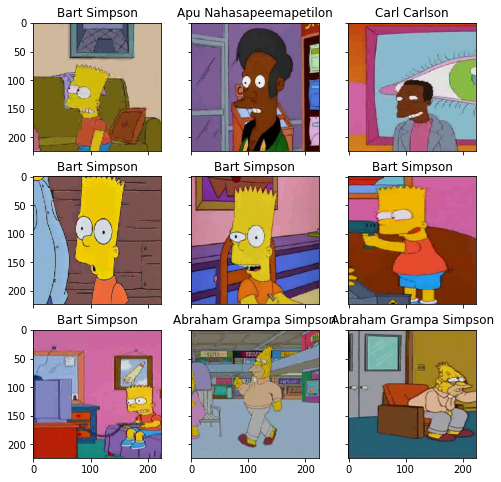

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

# Архитектура

In [0]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr = 0.001,momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        sheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=0.001,max_lr=0.01)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            sheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [0]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(new_train_files, mode='train')


Добавила scheduler  СycleLr + SGD , и использовола куытуе18)

In [0]:
from torchvision.models import resnet50

In [0]:
model = resnet18(pretrained=True)
torch.cuda.empty_cache()

In [0]:
model.layer1.requires_grad_=False
model.layer2.requires_grad_=False
model.layer3.requires_grad_=True
model.layer4.requires_grad_=False
model.fc = nn.Linear(512,42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [0]:
train(train_dataset,val_dataset,model,8,64)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 2.2602724140790076


epoch:  12%|█▎        | 1/8 [06:06<42:42, 366.01s/it]


Epoch 001 train_loss: 2.2603     val_loss 0.8107 train_acc 0.5765 val_acc 0.8922
loss 0.2741849627212919


epoch:  25%|██▌       | 2/8 [12:12<36:37, 366.25s/it]


Epoch 002 train_loss: 0.2742     val_loss 0.2583 train_acc 0.9249 val_acc 0.9352
loss 0.11641353542249323


epoch:  38%|███▊      | 3/8 [18:20<30:32, 366.58s/it]


Epoch 003 train_loss: 0.1164     val_loss 0.2092 train_acc 0.9670 val_acc 0.9532
loss 0.06957503107952129


epoch:  50%|█████     | 4/8 [24:27<24:27, 366.79s/it]


Epoch 004 train_loss: 0.0696     val_loss 0.2139 train_acc 0.9799 val_acc 0.9488
loss 0.045191987114048225


epoch:  62%|██████▎   | 5/8 [30:35<18:21, 367.05s/it]


Epoch 005 train_loss: 0.0452     val_loss 0.2373 train_acc 0.9876 val_acc 0.9469
loss 0.03267895930404074


epoch:  75%|███████▌  | 6/8 [36:42<12:14, 367.29s/it]


Epoch 006 train_loss: 0.0327     val_loss 0.1816 train_acc 0.9903 val_acc 0.9572
loss 0.026244940792718805


epoch:  88%|████████▊ | 7/8 [42:51<06:07, 367.79s/it]


Epoch 007 train_loss: 0.0262     val_loss 0.1950 train_acc 0.9931 val_acc 0.9591
loss 0.01880182405068413


epoch: 100%|██████████| 8/8 [48:59<00:00, 367.48s/it]


Epoch 008 train_loss: 0.0188     val_loss 0.2463 train_acc 0.9947 val_acc 0.9541


[(2.2602724140790076,
  0.5765243032436032,
  0.8107310169791738,
  tensor(0.8922, device='cuda:0', dtype=torch.float64)),
 (0.2741849627212919,
  0.9249025016646057,
  0.25831169980967095,
  tensor(0.9352, device='cuda:0', dtype=torch.float64)),
 (0.11641353542249323,
  0.9670408066203747,
  0.20919855530019657,
  tensor(0.9532, device='cuda:0', dtype=torch.float64)),
 (0.06957503107952129,
  0.9798820507942547,
  0.21394999740366996,
  tensor(0.9488, device='cuda:0', dtype=torch.float64)),
 (0.045191987114048225,
  0.9876343574621896,
  0.23734827573672024,
  tensor(0.9469, device='cuda:0', dtype=torch.float64)),
 (0.03267895930404074,
  0.9903452867877865,
  0.18155832048313372,
  tensor(0.9572, device='cuda:0', dtype=torch.float64)),
 (0.026244940792718805,
  0.9930562161133835,
  0.19501718221660055,
  tensor(0.9591, device='cuda:0', dtype=torch.float64)),
 (0.01880182405068413,
  0.9946732616760202,
  0.24627000854176603,
  tensor(0.9541, device='cuda:0', dtype=torch.float64))]

In [0]:
model.layer1.requires_grad_=False
model.layer2.requires_grad_=True
model.layer3.requires_grad_=True
model.layer4.requires_grad_=False

In [0]:
train(train_dataset,val_dataset,model,5,64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.015359833398555706


epoch:  20%|██        | 1/5 [06:08<24:32, 368.25s/it]


Epoch 001 train_loss: 0.0154     val_loss 0.1898 train_acc 0.9952 val_acc 0.9648
loss 0.011302221992739336


epoch:  40%|████      | 2/5 [12:17<18:25, 368.50s/it]


Epoch 002 train_loss: 0.0113     val_loss 0.2103 train_acc 0.9961 val_acc 0.9639
loss 0.01307372496699046


epoch:  60%|██████    | 3/5 [18:27<12:18, 369.05s/it]


Epoch 003 train_loss: 0.0131     val_loss 0.1693 train_acc 0.9963 val_acc 0.9698
loss 0.009696275219664971


epoch:  80%|████████  | 4/5 [24:36<06:09, 369.06s/it]


Epoch 004 train_loss: 0.0097     val_loss 0.1853 train_acc 0.9973 val_acc 0.9700
loss 0.013116178079071951


epoch: 100%|██████████| 5/5 [30:39<00:00, 367.96s/it]


Epoch 005 train_loss: 0.0131     val_loss 0.2676 train_acc 0.9960 val_acc 0.9498


[(0.015359833398555706,
  0.9952439836393037,
  0.18984241760273585,
  tensor(0.9648, device='cuda:0', dtype=torch.float64)),
 (0.011302221992739336,
  0.996147626747836,
  0.21031405002641732,
  tensor(0.9639, device='cuda:0', dtype=torch.float64)),
 (0.01307372496699046,
  0.9963378674022638,
  0.1693282144462329,
  tensor(0.9698, device='cuda:0', dtype=torch.float64)),
 (0.009696275219664971,
  0.9972890706744031,
  0.1852805439324428,
  tensor(0.9700, device='cuda:0', dtype=torch.float64)),
 (0.013116178079071951,
  0.9959573860934081,
  0.2675751327990028,
  tensor(0.9498, device='cuda:0', dtype=torch.float64))]

In [0]:
model.layer1.requires_grad_=True
model.layer2.requires_grad_=True
model.layer3.requires_grad_=True
model.layer4.requires_grad_=False

In [0]:
train(train_dataset,val_dataset,model,4,64)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 0.005432436006591234


epoch:  25%|██▌       | 1/4 [06:01<18:05, 361.90s/it]


Epoch 001 train_loss: 0.0054     val_loss 0.2117 train_acc 0.9984 val_acc 0.9597
loss 0.0074042074242690915


epoch:  50%|█████     | 2/4 [12:03<12:03, 361.77s/it]


Epoch 002 train_loss: 0.0074     val_loss 0.1859 train_acc 0.9978 val_acc 0.9683
loss 0.005943200572943167


epoch:  75%|███████▌  | 3/4 [18:04<06:01, 361.70s/it]


Epoch 003 train_loss: 0.0059     val_loss 0.1879 train_acc 0.9982 val_acc 0.9656
loss 0.007399665677673179


epoch: 100%|██████████| 4/4 [24:05<00:00, 361.45s/it]


Epoch 004 train_loss: 0.0074     val_loss 0.2025 train_acc 0.9977 val_acc 0.9662


[(0.005432436006591234,
  0.9983829544373632,
  0.21169983782657104,
  tensor(0.9597, device='cuda:0', dtype=torch.float64)),
 (0.0074042074242690915,
  0.9977646723104727,
  0.1859294592901455,
  tensor(0.9683, device='cuda:0', dtype=torch.float64)),
 (0.005943200572943167,
  0.9982402739465424,
  0.18788930589249903,
  tensor(0.9656, device='cuda:0', dtype=torch.float64)),
 (0.007399665677673179,
  0.9976695519832588,
  0.20252811737902346,
  tensor(0.9662, device='cuda:0', dtype=torch.float64))]

In [0]:
model.layer1.requires_grad_=True
model.layer2.requires_grad_=True
model.layer3.requires_grad_=True
model.layer4.requires_grad_=True

In [0]:
train(train_dataset,val_dataset,model,6,64)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 0.006569209498465632


epoch:  17%|█▋        | 1/6 [06:02<30:12, 362.49s/it]


Epoch 001 train_loss: 0.0066     val_loss 0.2159 train_acc 0.9982 val_acc 0.9683
loss 0.0043388811151601064


epoch:  33%|███▎      | 2/6 [12:05<24:10, 362.54s/it]


Epoch 002 train_loss: 0.0043     val_loss 0.1926 train_acc 0.9988 val_acc 0.9679


**bold text**### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [0]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [0]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [0]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [0]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons120.csv', index=False)


In [0]:
! ls 

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
